In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns           # plt and sns to visualise outputs
import tensorflow as tf         # required because it is a depedency to use keras
from tensorflow import keras  # Open Source Neural Network library to construct any deep learning algorithm

In [2]:
14# os.listdir("../input/chest-xray-pneumonia/chest_xray")
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)   #Path to dataset
train_path = os.path.join(path, "chest_xray/train")
test_path = os.path.join(path, "chest_xray/test")
val_path = os.path.join(path, "chest_xray/val")
print(test_path,"\n", train_path,"\n", val_path,"\n")
print(os.listdir(path))
print(os.listdir(train_path))
print(os.listdir(test_path))
print(os.listdir(val_path))

100%|██████████| 2.29G/2.29G [00:15<00:00, 156MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test 
 /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train 
 /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val 

['chest_xray']
['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']


In [3]:
pnemonia = "PNEUMONIA"
normal = "NORMAL"

# Train, test and validate datasets
trainPneumoniaPath = os.path.join(train_path, pnemonia)
pneumoniaItems = os.listdir(trainPneumoniaPath)
lenPneumoniaTrainSet = len(os.listdir(trainPneumoniaPath))
print(lenPneumoniaTrainSet)
trainNormalPath = os.path.join(train_path, normal)
normalItems = os.listdir(trainNormalPath)
lenNormalTrainSet = len(os.listdir(trainNormalPath))
print(lenNormalTrainSet)

testPneumoniaPath = os.path.join(test_path, pnemonia)
lenPneumoniaTestSet = len(os.listdir(testPneumoniaPath))
print(lenPneumoniaTestSet)
testNormalPath = os.path.join(test_path, normal)
lenNormalTestSet = len(os.listdir(testNormalPath))
print(lenNormalTestSet)

valPneumoniaPath = os.path.join(val_path, pnemonia)
lenPneumoniaValSet = len(os.listdir(valPneumoniaPath))
print(lenPneumoniaValSet)
valNormalPath = os.path.join(val_path, normal)
lenNormalValSet = len(os.listdir(valNormalPath))
print(lenNormalValSet)

3875
1341
390
234
8
8


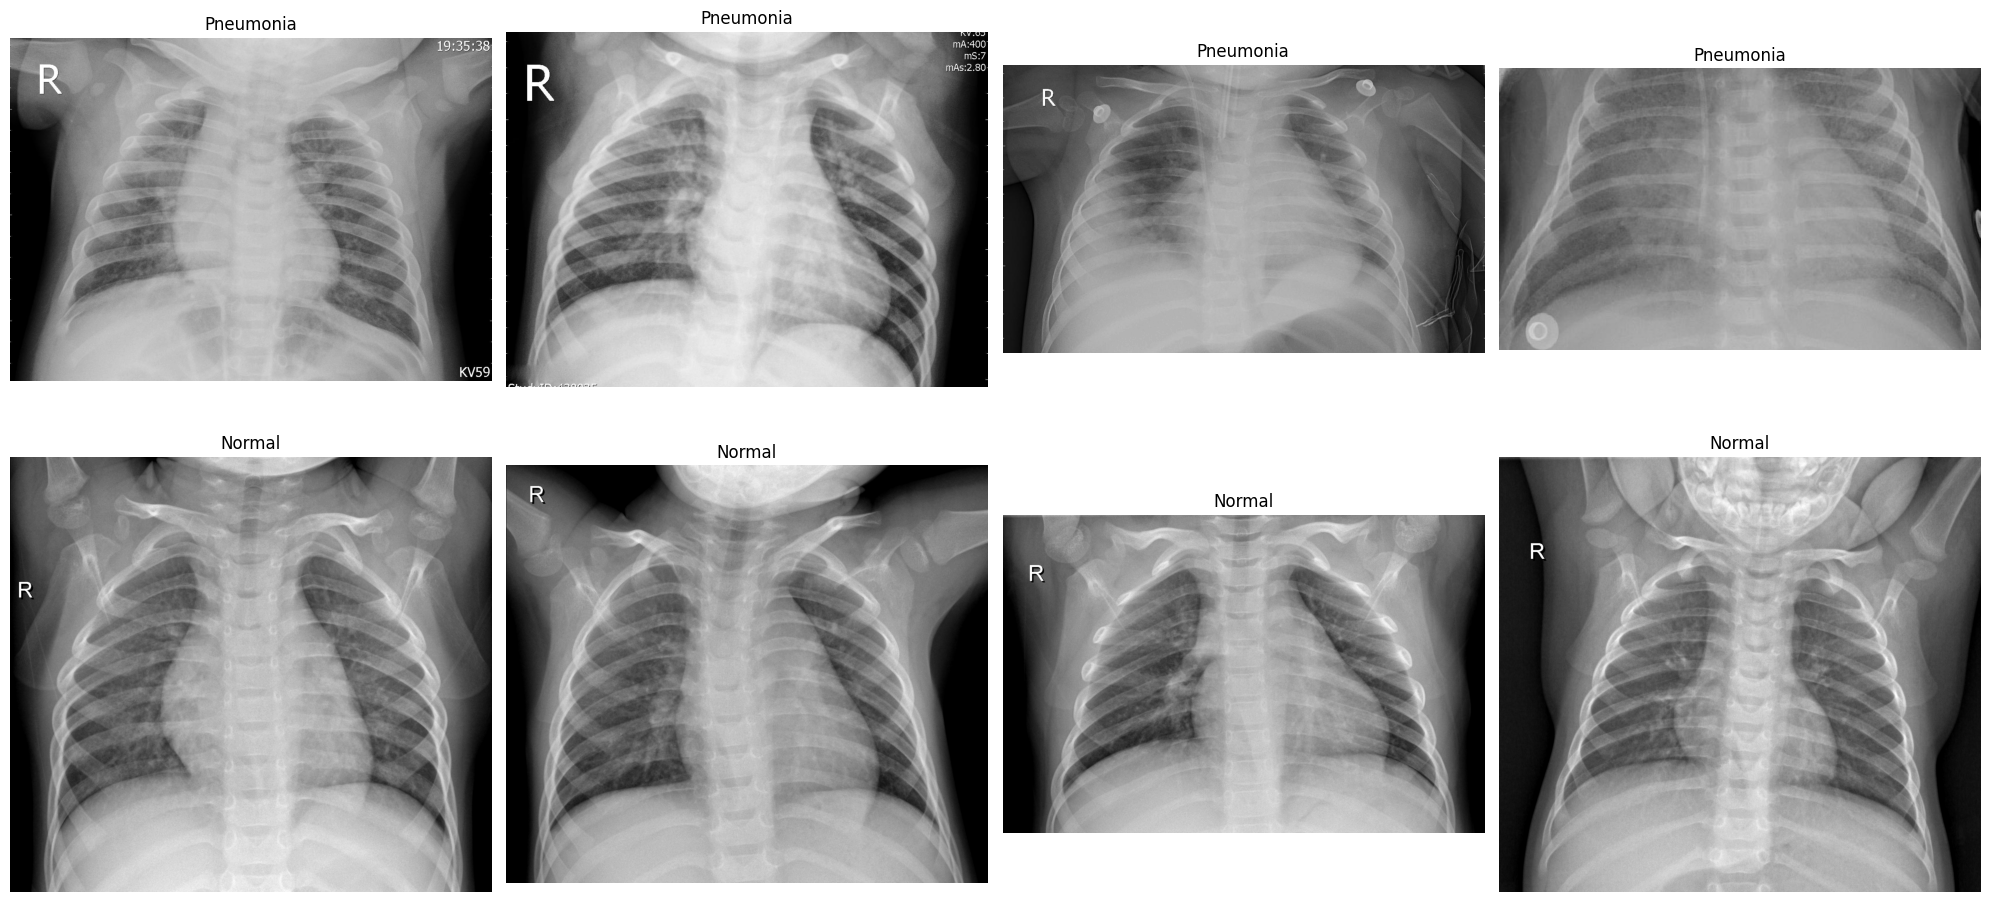

In [4]:
# Showing dataset samples

plt.subplots(2,4,figsize = (20,10))

for i in range(4):
  plt.subplot(2,4,i+1)
  img = plt.imread(os.path.join(trainPneumoniaPath, pneumoniaItems[i]))
  plt.imshow(img, cmap = "gray")
  plt.title("Pneumonia")
  plt.axis('off')

# plt.tight_layout()

for i in range(4,8):
  plt.subplot(2,4,i+1)
  img = plt.imread(os.path.join(trainNormalPath, normalItems[i]))
  plt.imshow(img, cmap = "gray")
  plt.title("Normal")
  plt.axis('off')

plt.tight_layout()

Text(0.5, 0.98, 'Raw chest X-ray Images: Normal')

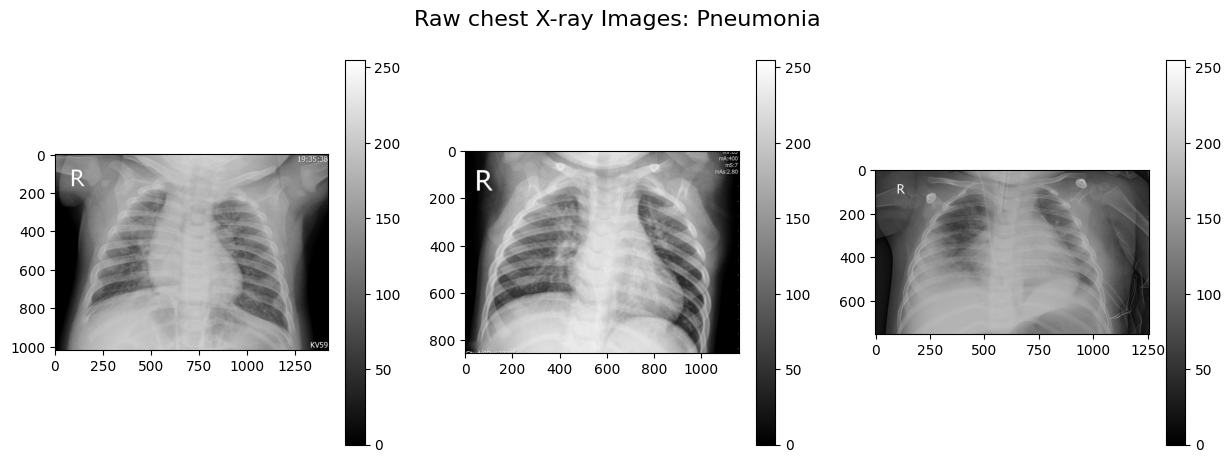

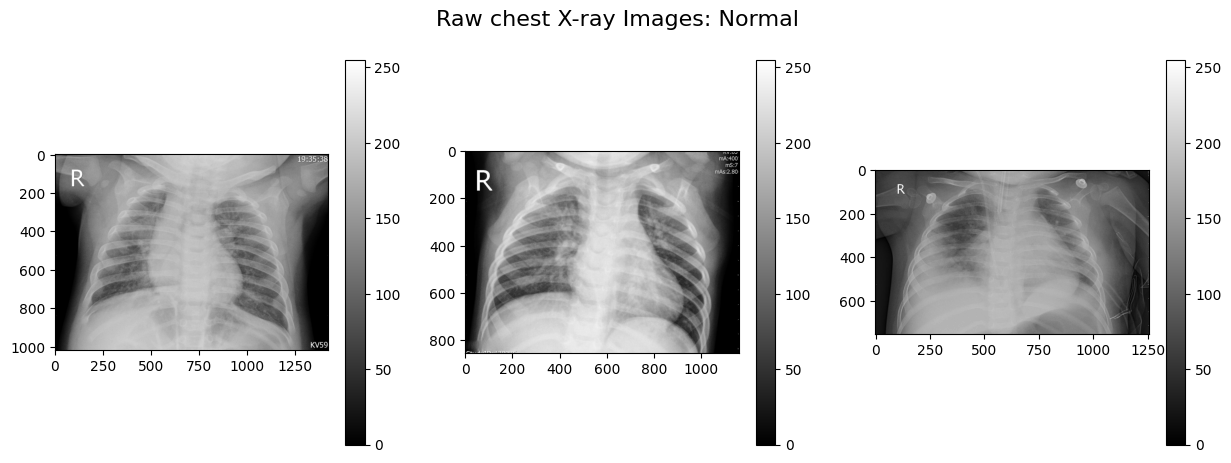

In [5]:
# Normal X Ray images
import random
# normalImages = random.sample(normalItems, 3)
# pneumoniaImages = random.sample(pneumoniaItems, 3)

normalImages = normalItems[:3]
pneumoniaImages = pneumoniaItems[:3]

# Plotting Raw chest images of pnemonia samples
fig, axes = plt.subplots(1,3,figsize =(15,5))
for i, image_name in enumerate(pneumoniaImages):
  plt.subplot(1,3,i+1)
  img_path = os.path.join(trainPneumoniaPath, image_name)
  sampleImages = plt.imread(img_path)
  plt.imshow(sampleImages, cmap = "gray")
  plt.colorbar()

# Plotting Raw chest images of normal samples
fig1, axes2 = plt.subplots(1,3,figsize =(15,5))
for i, image_name in enumerate(pneumoniaImages):
  plt.subplot(1,3,i+1)
  img_path = os.path.join(trainPneumoniaPath, image_name)
  sampleImages = plt.imread(img_path)
  plt.imshow(sampleImages, cmap = "gray")
  plt.colorbar()


fig.suptitle("Raw chest X-ray Images: Pneumonia", fontsize=16)
fig1.suptitle("Raw chest X-ray Images: Normal", fontsize=16)

In [6]:
# Image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    samplewise_center = True,
    samplewise_std_normalization = True
)

In [7]:
trainedData = image_generator.flow_from_directory(
                train_path,
                batch_size = 8,
                shuffle = True,
                class_mode = 'binary',
                target_size = (225,225)
)

Found 5216 images belonging to 2 classes.


The dimensions of image are (8, 225, 225, 3)


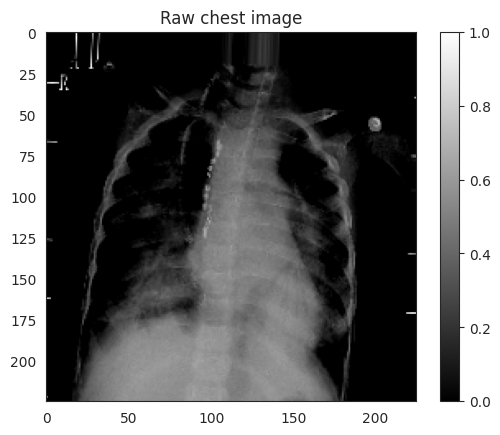

In [8]:
sns.set_style('white')
generated_image, label = trainedData.__getitem__(0)
normalisedImage = generated_image[0] /generated_image[0].max()
plt.imshow(normalisedImage, cmap = "gray")
plt.colorbar()
plt.title('Raw chest image')

print(f"The dimensions of image are {generated_image.shape}")

In [9]:
wtPneumonia = lenPneumoniaTrainSet/(lenPneumoniaTrainSet + lenNormalTrainSet)
wtNormal = lenNormalTrainSet/(lenPneumoniaTrainSet + lenNormalTrainSet)

classWt = {0 : wtNormal, 1 : wtPneumonia}

print(f"Weight for class Pneumonia : {wtPneumonia:.2f}")
print(f"Weight for class Normal : {wtNormal:.2f}")

Weight for class Pneumonia : 0.74
Weight for class Normal : 0.26


In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization

model = Sequential()
# A convolutional layer is a fundamental building block of a Convolutional Neural Network (CNN), primarily used for processing and analyzing images. Its main role is to extract features, such as edges, textures, and patterns, from the input data.

# Convolution operation acts as edge detector

# Each filter in a layer helps in recogning a feature of image like vertical edge detection, horizontal edges, circles, diagonal edges, shapes, etc.

#Layer1
#kernel_size is the image filter size used in convolution
model.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape = (225,225,3), activation = 'relu'))
# BatchNormalization is used to standardize the input of next layer by recentering and rescaling the output of current layers.
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape = (225,225,3),activation = 'relu'))
model.add(BatchNormalization())
# Pooling is a process to minimise the dimensions of an image while preserving the features of the image
# Max pooling Reduces the size of the image and enhances or sharpens the image by selecting max value from pixel matrix with fixed stride value instead of adding.
model.add(MaxPool2D(pool_size=(2,2)))


#Layer2
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = (225, 225, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = (225, 225, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

#Layer3
model.add(Conv2D(filters = 128, kernel_size = (3,3), input_shape = (225, 225, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3), input_shape = (225, 225, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

#Layer4
model.add(Conv2D(filters = 256, kernel_size = (3,3), input_shape = (225, 225, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3), input_shape = (225, 225, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# Each filter produces one feature map. For example, if you have 32 filters in a layer, you will end up with 32 feature maps.

#  Feature maps help reduce the dimensionality of the input while preserving essential features, making it easier for the network to learn and generalize.

# Flatten() layer is used to convert multi-dimensional input (such as the output from convolutional layers) into a one-dimensional array. This is essential because fully connected (dense) layers, which often come after convolutional and pooling layers, require a flat input.

model.add(Flatten())
# Dense needs a 1D vector input, So images are flattened into single dimension using a flattening layer

# The purpose of the dense layer is to learn a linear combination of its inputs, which can help the model make predictions based on the features extracted by previous layers (like convolutional and pooling layers).
model.add(Dense(256, activation = 'relu'))


model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 223, 223, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 223, 223, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 221, 221, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 221, 221, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 108, 108, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 106, 106, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 51, 51, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 49, 49, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 256)         │         590,0

 Total params: 7,730,209 (29.49 MB)

 Trainable params: 7,728,289 (29.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [11]:
test = image_generator.flow_from_directory(test_path, batch_size = 1, shuffle = False, class_mode = 'binary', target_size = (225,225))

Found 624 images belonging to 2 classes.


In [12]:
result = model.fit(trainedData,
          epochs = 10,
          validation_data = test,
          class_weight = classWt,
          steps_per_epoch = 100,
          validation_steps = 25)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 370s 4s/step - accuracy: 0.7694 - loss: 1.4198 - val_accuracy: 0.0400 - val_loss: 5.7256
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.7987 - loss: 0.3058 - val_accuracy: 0.0000e+00 - val_loss: 45.1132
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 367s 4s/step - accuracy: 0.8085 - loss: 0.1368 - val_accuracy: 0.0400 - val_loss: 7.5760
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 370s 4s/step - accuracy: 0.8559 - loss: 0.1151 - val_accuracy: 0.2400 - val_loss: 2.7172
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 366s 4s/step - accuracy: 0.8919 - loss: 0.1131 - val_accuracy: 0.0000e+00 - val_loss: 7.0389
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.8647 - loss: 0.1001 - val_accuracy: 0.0000e+00 - val_loss: 21.7171
Epoch 7/10
 52/100 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - accuracy: 0.8110 - loss: 0.1031

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.8221 - loss: 0.0997 - val_accuracy: 0.0400 - val_loss: 10.6039
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.8999 - loss: 0.1016 - val_accuracy: 0.4000 - val_loss: 1.1702
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 364s 4s/step - accuracy: 0.8719 - loss: 0.1187 - val_accuracy: 0.0000e+00 - val_loss: 3.1491
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.8911 - loss: 0.0987 - val_accuracy: 0.8800 - val_loss: 0.3171


Text(0.5, 1.0, 'Accuracy Evolution')

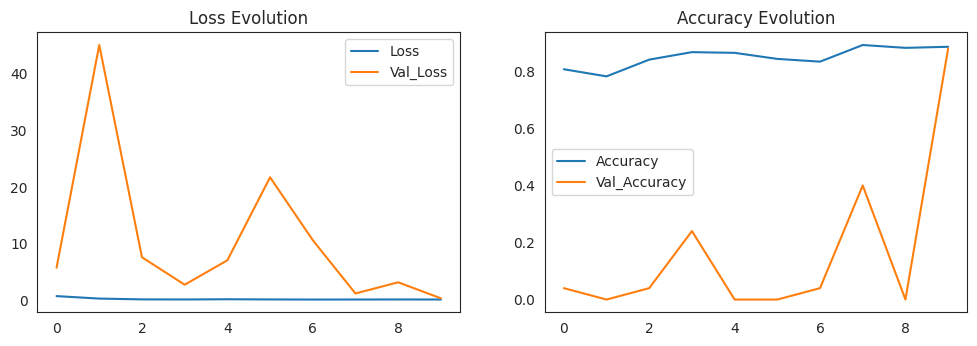

In [13]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(result.history['loss'], label='Loss')
plt.plot(result.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(result.history['accuracy'], label='Accuracy')
plt.plot(result.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [15]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(trainedData)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - accuracy: 0.8540 - loss: 0.4739
Test Accuracy: 82.21%
652/652 ━━━━━━━━━━━━━━━━━━━━ 595s 912ms/step - accuracy: 0.8372 - loss: 0.3619
Train Accuracy: 83.51%


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

624/624 ━━━━━━━━━━━━━━━━━━━━ 72s 114ms/step
[[195  39]
 [ 74 316]]


,0,1,accuracy,macro avg,weighted avg
precision,0.724907,0.890141,0.81891,0.807524,0.828178
recall,0.833333,0.810256,0.81891,0.821795,0.818910
f1-score,0.775348,0.848322,0.81891,0.811835,0.820957
support,234.000000,390.000000,0.81891,624.000000,624.000000


In [17]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[220  14]
 [136 254]]


,0,1,accuracy,macro avg,weighted avg
precision,0.617978,0.947761,0.759615,0.782869,0.824092
recall,0.940171,0.651282,0.759615,0.795726,0.759615
f1-score,0.745763,0.772036,0.759615,0.758900,0.762184
support,234.000000,390.000000,0.759615,624.000000,624.000000
